### Konfiguracja nowego klienta Hazelcast

In [45]:
import hazelcast

client = hazelcast.HazelcastClient(
            cluster_name = "dev",
            cluster_members=["127.0.0.1:5701", "127.0.0.1:5702", "127.0.0.1:5703"],
        )


Debug - sprawdzenie typu klucza: 

In [23]:
imap = client.get_map("trades").blocking()
entry_set = imap.entry_set()
first_key, _ = next(iter(entry_set))
print(f"Key type: {type(first_key)}") 
print(f"Value type: {type(_)}") 

Key type: <class 'str'>
Value type: <class 'hazelcast.core.HazelcastJsonValue'>


### Mapping SQL - prosty przykład

In [9]:
cities = client.get_map("cities").blocking()

client.sql.execute(
    """
CREATE MAPPING cities (
__key INT,
countries VARCHAR,
cities VARCHAR)
TYPE IMap
OPTIONS('keyFormat'='int', 'valueFormat'='json-flat')

    """
).result()

client.sql.execute(
    """
INSERT INTO cities VALUES
(1, 'United Kingdom','London'),
(2, 'United Kingdom','Manchester'),
(3, 'United States', 'New York'),
(4, 'United States', 'Los Angeles'),
(5, 'Turkey', 'Ankara'),
(6, 'Turkey', 'Istanbul'),
(7, 'Brazil', 'Sao Paulo'),
(8, 'Brazil', 'Rio de Janeiro')
    """
).result()

result = client.sql.execute("SELECT * FROM cities").result()


In [32]:
for row in result:
    print(row)

[__key INTEGER=2, countries VARCHAR=United Kingdom, cities VARCHAR=Manchester]
[__key INTEGER=7, countries VARCHAR=Brazil, cities VARCHAR=Sao Paulo]
[__key INTEGER=1, countries VARCHAR=United Kingdom, cities VARCHAR=London]
[__key INTEGER=3, countries VARCHAR=United States, cities VARCHAR=New York]
[__key INTEGER=6, countries VARCHAR=Turkey, cities VARCHAR=Istanbul]
[__key INTEGER=5, countries VARCHAR=Turkey, cities VARCHAR=Ankara]
[__key INTEGER=8, countries VARCHAR=Brazil, cities VARCHAR=Rio de Janeiro]
[__key INTEGER=4, countries VARCHAR=United States, cities VARCHAR=Los Angeles]


In [36]:
# Zamknięcie klienta Hazelcast
client.shutdown()

### Zapytania SQL - Trades

Mapa przechowywująca wszystkie transakcje, przechwycane z websocketa i umieszczane w czasie rzeczywistym, dla kursów:
* BTC-USD
* ETH-USD

A więc analizę danych możemy wykonać po stronie tego klienta.

In [58]:
#trades = client.get_map("coinbase_trades").blocking()

client.sql.execute("""
        CREATE OR REPLACE MAPPING trades (
            trade_id VARCHAR,
            product_id VARCHAR,
            price DOUBLE,
            volume DOUBLE,
            time_iso VARCHAR,
            time_unix BIGINT,
            side VARCHAR
        )
        TYPE IMap
        OPTIONS (
            'keyFormat' = 'varchar',
            'valueFormat' = 'json-flat'
        )
        """)


In [29]:
result_trades = client.sql.execute(
    """  
    SELECT  * 
    FROM trades 
    where cast(price  as decimal) > 99416
    LIMIT 10
    """).result()

for row in result_trades:
    print(row)

[trade_id VARCHAR=934169169391058946, product_id VARCHAR=BTC-USD, price DOUBLE=106721.41, volume DOUBLE=2.71e-05, time_iso VARCHAR=2025-01-21T19:34:50.389162Z, time_unix BIGINT=1737488090389, side VARCHAR=buy]
[trade_id VARCHAR=934169169391124482, product_id VARCHAR=BTC-USD, price DOUBLE=106721.4, volume DOUBLE=9.369e-05, time_iso VARCHAR=2025-01-21T19:34:50.567447Z, time_unix BIGINT=1737488090567, side VARCHAR=sell]
[trade_id VARCHAR=934169214596481025, product_id VARCHAR=BTC-USD, price DOUBLE=106734.07, volume DOUBLE=0.00010306, time_iso VARCHAR=2025-01-21T19:35:01.940417Z, time_unix BIGINT=1737488101940, side VARCHAR=buy]
[trade_id VARCHAR=934169201089970179, product_id VARCHAR=BTC-USD, price DOUBLE=106721.41, volume DOUBLE=2.19e-05, time_iso VARCHAR=2025-01-21T19:34:56.601407Z, time_unix BIGINT=1737488096601, side VARCHAR=buy]
[trade_id VARCHAR=934169201089773571, product_id VARCHAR=BTC-USD, price DOUBLE=106721.41, volume DOUBLE=0.03832658, time_iso VARCHAR=2025-01-21T19:34:56.6014

### Średnia cena w interwałach czasowych (10 min)

In [17]:
query =   """
    SELECT 
    CAST(FLOOR(time_unix / 600000) * 600000 AS BIGINT) AS time_bucket,
    AVG(price) AS avg_price
    FROM trades
    WHERE product_id = 'BTC-USD'
    GROUP BY time_bucket
    ORDER BY time_bucket;

    """

[datetime.datetime(2025, 1, 21, 19, 30)]


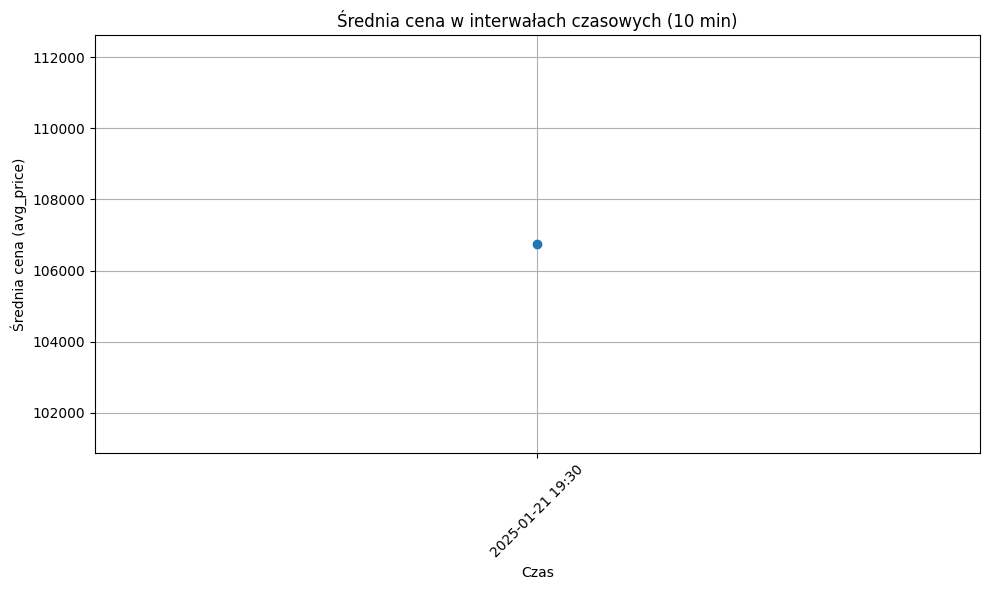

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

result_trades = client.sql.execute(query).result()

def convert_time_bucket_to_datetime(time_bucket):
    return datetime.utcfromtimestamp(time_bucket / 1000)

time_buckets = []
avg_prices = []

for row in result_trades:
    time_buckets.append(convert_time_bucket_to_datetime(row["time_bucket"]))
    avg_prices.append(row["avg_price"])

print(time_buckets)
# Tworzenie DataFrame
df = pd.DataFrame({"time_bucket": time_buckets, "avg_price": avg_prices})

plt.figure(figsize=(10, 6))
plt.plot(df["time_bucket"], df["avg_price"], marker='o')
plt.title("Średnia cena w interwałach czasowych (10 min)")
plt.xlabel("Czas")
plt.ylabel("Średnia cena (avg_price)")

plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M'))

plt.xticks(time_buckets, rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()

###  Top 10 transakcji o najwyższej cenie

In [19]:
query= """
    SELECT 
        time_unix AS transaction_time,
        price AS price,
        volume AS volume
    FROM trades
    WHERE product_id = 'BTC-USD'
    ORDER BY price DESC
    LIMIT 10;

    """
result_trades = client.sql.execute(query).result()

result_trades_dict = []
for row in result_trades:
    trade = {
        "transaction_time": row["transaction_time"],  
        "price": row["price"],
        "volume": row["volume"]
    }
    trade["transaction_time"] = datetime.utcfromtimestamp(trade["transaction_time"] / 1000).strftime('%Y-%m-%d %H:%M')
    result_trades_dict.append(trade)

df = pd.DataFrame(result_trades_dict)
print(df)

   transaction_time      price    volume
0  2025-01-21 19:35  106787.84  0.000350
1  2025-01-21 19:35  106787.30  0.000182
2  2025-01-21 19:35  106787.29  0.000303
3  2025-01-21 19:35  106787.28  0.000032
4  2025-01-21 19:35  106787.27  0.000996
5  2025-01-21 19:35  106787.26  0.000426
6  2025-01-21 19:35  106787.25  0.000454
7  2025-01-21 19:35  106787.24  0.000051
8  2025-01-21 19:35  106787.23  0.000219
9  2025-01-21 19:35  106787.22  0.000420


### Średnia cena transakcji w stosunku do godziny dnia

   hour_of_day      avg_price
0           19  106743.973733


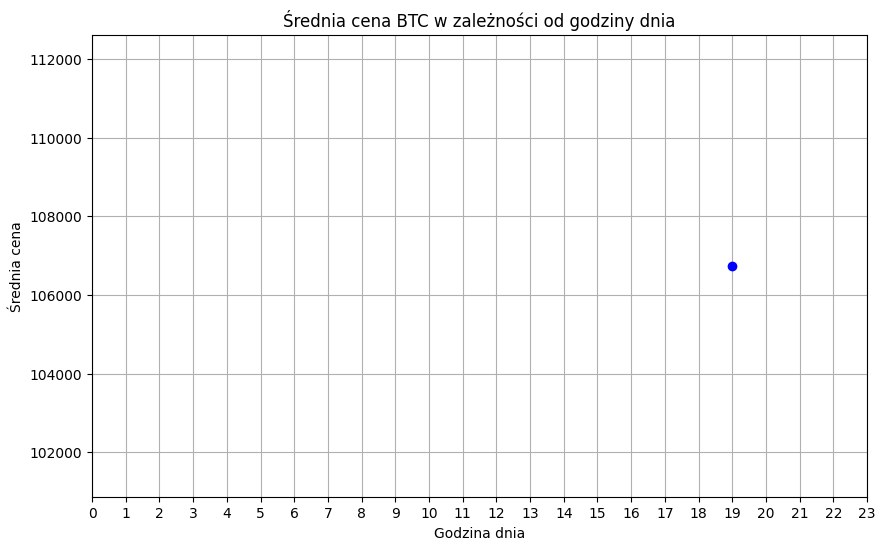

In [20]:
import pandas as pd
from datetime import datetime

query = """

SELECT 
    CAST((time_unix / 3600000) % 24 AS INT) AS hour_of_day,
    AVG(price) AS avg_price
FROM trades
WHERE product_id = 'BTC-USD'
GROUP BY hour_of_day
ORDER BY hour_of_day;

"""

result_trades = client.sql.execute(query).result()

result_trades_dict = []
for row in result_trades:
    trade = {
        "hour_of_day": row["hour_of_day"],
        "avg_price": row["avg_price"]
    }
    result_trades_dict.append(trade)

df = pd.DataFrame(result_trades_dict)
print(df)

plt.figure(figsize=(10, 6))
plt.plot(df['hour_of_day'], df['avg_price'], marker='o', linestyle='-', color='b')
plt.title('Średnia cena BTC w zależności od godziny dnia')
plt.xlabel('Godzina dnia')
plt.ylabel('Średnia cena')
plt.grid(True)
plt.xticks(range(24))  
plt.show()

### Procentowy udział transakcji Buy vs Sell w ciągu ostatniej godziny

1737484929698


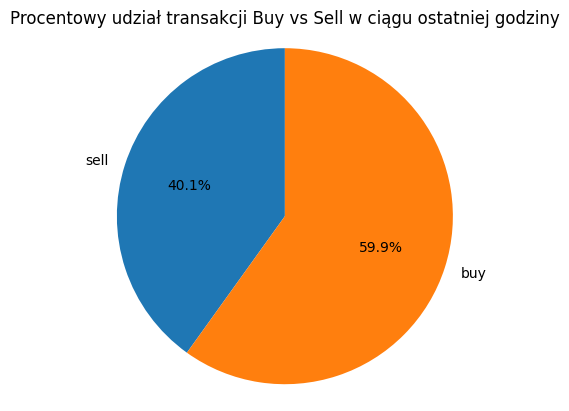

In [22]:
from collections import Counter

from datetime import datetime

current_timestamp = int(datetime.utcnow().timestamp() * 1000)
print(current_timestamp)

query = f"""
SELECT 
    side AS transaction_type,
    time_unix AS transaction_time
FROM trades
WHERE product_id = 'BTC-USD'
    AND time_unix > {current_timestamp - 3600000} 
ORDER BY transaction_time;

"""

result_trades = client.sql.execute(query).result()

transaction_types = [trade["transaction_type"] for trade in result_trades]

counter = Counter(transaction_types)

labels = counter.keys()
sizes = counter.values()

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal') 

plt.title("Procentowy udział transakcji Buy vs Sell w ciągu ostatniej godziny")
plt.show()

### SQL - Aggregated Trades

Mapa przechowywująca zagregowane dane na temat dwóch kursów: 
* BTC-USD
* ETH-USD

In [24]:
client.sql.execute("""
CREATE OR REPLACE MAPPING aggregated_trades (
    product_id VARCHAR,
    average_price DOUBLE,
    total_volume DOUBLE,
    last_updated BIGINT
)
TYPE IMap
OPTIONS (
    'keyFormat' = 'varchar',
    'valueFormat' = 'json-flat'
)
""")

In [ ]:

query = '''
SELECT 
    product_id,
    average_price,
    total_volume,
    last_updated
FROM aggregated_trades
ORDER BY last_updated DESC;
'''

result_trades = client.sql.execute(query).result()
result_trades_dict = []
for row in result_trades:
    trade = {
        "product_id": row["product_id"],  
        "average_price": row["average_price"],
        "average_price": row["average_price"]
    }
    trade["last_updated"] =        datetime.fromtimestamp(row["last_updated"] / 1000).strftime('%Y-%m-%d %H:%M:%S')  # Konwersja timestamp na czytelny format

    result_trades_dict.append(trade)

df = pd.DataFrame(result_trades_dict)
print(df)

  product_id  average_price         last_updated
0    BTC-USD  106743.430129  2025-01-21 20:35:07
1    ETH-USD    3323.026796  2025-01-21 20:35:07


### Subskrypcja do Topic

In [56]:
import json, time
from hazelcast.core import HazelcastJsonValue

def on_message(event):
    print("Got message:", event.message)
    print("Publish time:", event.publish_time)

client = hazelcast.HazelcastClient()

large_trades_topic = client.get_topic("large_trades_1").blocking()



large_trades_topic.add_listener(on_message)

print("Waiting for messages on the topic...")

# Symulacja publikacji wiadomości na topicu
large_trades_topic.publish("1234")

time.sleep(10)

Waiting for messages on the topic...


In [59]:
import hazelcast
import time


def on_message(event):
    print("Got message:", event.message)
    print("Publish time:", event.publish_time)


client = hazelcast.HazelcastClient()

topic = client.get_topic("topic").blocking()
topic.add_listener(on_message)

for i in range(10):
    topic.publish("Message " + str(i))
    time.sleep(0.1)

topic.publish_all(["m1", "m2", "m3", "m4", "m5"])
time.sleep(1)

client.shutdown()

Got message: Message 0
Publish time: 1737495520.06
Got message: Message 1
Publish time: 1737495520.17
Got message: Message 2
Publish time: 1737495520.28
Got message: Message 3
Publish time: 1737495520.386
Got message: Message 4
Publish time: 1737495520.49
Got message: Message 5
Publish time: 1737495520.593
Got message: Message 6
Publish time: 1737495520.699
Got message: Message 7
Publish time: 1737495520.803
Got message: Message 8
Publish time: 1737495520.906
Got message: Message 9
Publish time: 1737495521.011
Got message: m1
Publish time: 1737495521.116
Got message: m2
Publish time: 1737495521.116
Got message: m3
Publish time: 1737495521.116
Got message: m4
Publish time: 1737495521.116
Got message: m5
Publish time: 1737495521.116
